In [1]:
from torch import nn

In [88]:
batch_size = 64
n_epoch = 10
lr = 1.e-3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Load MNIST dataset


In [140]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1), # Add noise
        transforms.Normalize((0.5,), (0.5,)),

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [141]:

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

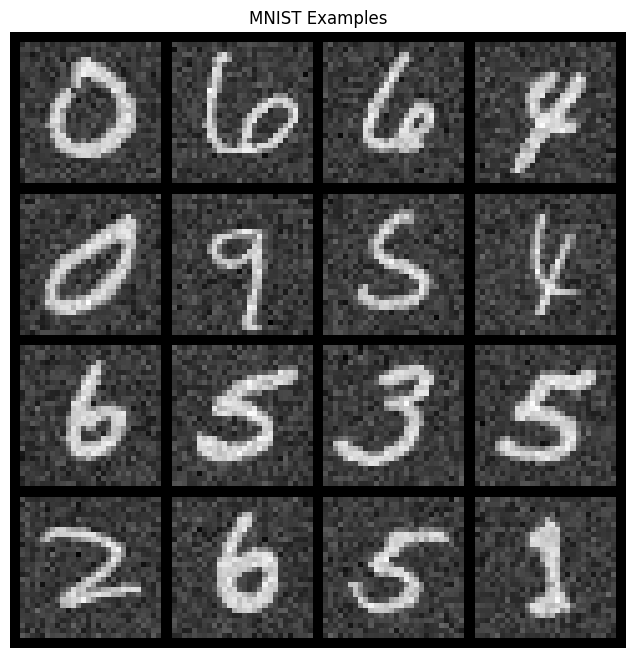

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Make a grid of images
grid = vutils.make_grid(images[:16], nrow=4, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.title('MNIST Examples')
plt.axis('off')
plt.show()

In [143]:
class Encoder(nn.Module):
    def __init__(self, lattent_dim = 16):
        super(Encoder, self).__init__()
        self.lattent_dim = lattent_dim
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(32*7*7, lattent_dim)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [144]:
class Decoder(nn.Module):
    def __init__(self, lattent_dim = 16):
        super(Decoder, self).__init__()
        self.lattent_dim = lattent_dim
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3,stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu2 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(lattent_dim, 32*7*7)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 7, 7)
        x = self.relu1(self.deconv1(x))
        x = self.sigmoid(self.deconv2(x))
        return x

In [145]:
class Autoencoder(nn.Module):
    def __init__(self, lattent_dim = 16):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(lattent_dim)
        self.decoder = Decoder(lattent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [146]:
x, y = next(iter(trainloader))

In [147]:
model = Autoencoder( lattent_dim=16)
opim = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [ ]:
for i in range(n_epoch):
  model.train()
  visu_loss = 0
  for x, _ in trainloader:
    opim.zero_grad()
    x_hat = model(x)
    loss = criterion(x, x_hat)
    loss.backward()
    opim.step()
    visu_loss += loss.item()
  print('epoch train %d : %f '%(i, visu_loss / len(trainloader)))
  model.eval()
  with torch.no_grad():
    visu_loss_test = 0
    for x, _ in testloader:
      x_hat = model(x)
      loss = criterion(x, x_hat)
      visu_loss_test += loss.item()
    print('epoch test %d : %f '%(i, visu_loss_test / len(testloader)))


epoch train 0 : 0.984883 
epoch test 0 : 0.929566 
epoch train 1 : 0.969098 
epoch test 1 : 0.929566 
